In [1]:
# Визуализации

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("bmh")
plt.rcParams["axes.titlesize"] = "large"

In [2]:
# Общеe

import os
import tqdm
import pathlib
import numpy as np
import pandas as pd

tqdm.tqdm.pandas()
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

<div class="alert alert-block alert-warning">
Не забудьте заменить <tt>DATA_DIR</tt> на имя локальной директории, в которую сохранили файл.
</div>

In [14]:
DATA_DIR = pathlib.Path("../data/2/dataset/")
RS = 3984765

# Загрузка данных

Данные хранятся в формате Parquet: читается быстрее, места занимает меньше.

In [17]:
train = pd.read_parquet(DATA_DIR.joinpath("train.parquet"))
train.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,target0,target1
0,32.910908,17.376350,77.557840,2.929855,gas1,20.487150,57.633085,49.245392,-44.124381,23.400064,-28.640648,-10.995420,40.856313,29.912800,33.168114,18.769718,41.812507,14.203652,9.689942,17.951627,24.198589,102.448710,110.529868,56.817260,12.887802,27.050891,6.502743
1,41.263782,22.419445,47.945514,-25.847472,gas2,21.461239,3.474080,49.659980,-13.553188,-13.047593,-12.445940,16.657368,42.453280,99.792375,127.159321,-13.180244,50.722470,-14.451904,-0.906120,105.724742,-9.435222,-16.060150,37.286110,61.224272,39.822424,84.127890,76.578716
2,25.580283,17.376350,77.654180,2.799411,gas1,20.487150,28.938295,49.245392,-44.124381,20.610679,-28.641150,-1.886830,40.927941,16.340674,60.760647,18.658501,52.731646,14.395054,9.779019,17.951638,24.999453,101.728213,111.471534,52.664304,12.887802,22.080133,3.036043
3,33.756900,17.376350,73.049625,2.953982,gas1,20.487150,28.932311,49.245392,-44.124381,18.107963,-28.642094,16.284415,40.869406,43.707663,48.037510,18.771030,52.305692,14.184314,9.798969,17.951675,23.990300,101.312113,115.589451,56.840719,12.887802,30.234082,8.910795
4,4.223732,38.772534,48.015553,-25.843943,gas2,24.635721,12.011581,51.030938,84.244199,-17.735680,40.395582,16.557978,65.988300,91.081310,150.949700,-13.172169,51.012294,-14.439953,8.262354,90.187207,-2.901661,-16.060150,37.398779,40.488468,128.295838,71.128092,50.475082


В данных есть один категориальный признак: `feature4`. Он может принимать значения `gas1` и `gas2`. Таргета два: `target0` и `target1`.

In [7]:
CAT = ["feature4"]
TARGETS = ["target0", "target1"]
FTS = train.filter(like="feature").columns.difference(CAT)

Проверяем, что с пропусками:

In [8]:
train.isnull().any().mean()

0.0

Их нет! Вот это поворот! Посмотрим на таргеты:

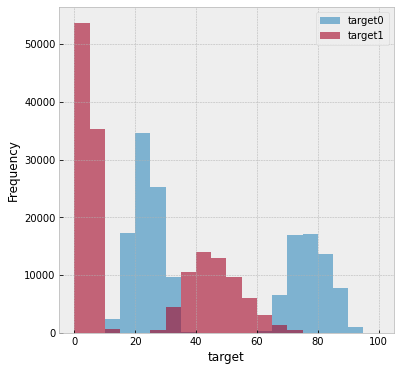

In [9]:
plt.figure(figsize=(6,6))

train[TARGETS].plot(kind="hist", range=(0, 100), bins=20, alpha=0.6, ax=plt.gca())
plt.xlabel("target");

Категориальный признак меняем на числовой:

In [10]:
train["gas"] = 0
train.loc[train.feature4=="gas2", "gas"] = 1

In [11]:
FTS = FTS.union(["gas"])

# Простая модель

Построим простую модель со случайным разбиением на тренировочное и валидационное множества. Таргеты будем моделировать отдельно.

In [12]:
X_tr, X_val, y_tr, y_val = train_test_split(train[FTS], train[TARGETS], train_size=0.5, random_state=RS)

In [13]:
models = {}
tr_preds = []
val_preds = []

for tg in TARGETS:
    print(f"{tg}", "=" * 10)
    cb_model = CatBoostRegressor(max_depth=4, iterations=5000,
                                 early_stopping_rounds=20, objective="MAPE", verbose=200,
                                 random_state=RS)
    cb_model.fit(X_tr, y_tr[tg], eval_set=(X_val, y_val[tg]))

    tr_preds.append(cb_model.predict(X_tr))
    val_preds.append(cb_model.predict(X_val))

    models[tg] = cb_model

target0 ==========
0:	learn: 0.3877709	test: 0.3877383	best: 0.3877383 (0)	total: 53.3ms	remaining: 4m 26s
200:	learn: 0.0636667	test: 0.0637503	best: 0.0637503 (200)	total: 1s	remaining: 23.9s
400:	learn: 0.0234490	test: 0.0235906	best: 0.0235906 (400)	total: 1.93s	remaining: 22.1s
600:	learn: 0.0152728	test: 0.0153717	best: 0.0153717 (600)	total: 2.89s	remaining: 21.2s
800:	learn: 0.0127230	test: 0.0128291	best: 0.0128291 (800)	total: 3.86s	remaining: 20.2s
1000:	learn: 0.0111387	test: 0.0112631	best: 0.0112631 (1000)	total: 4.79s	remaining: 19.2s
1200:	learn: 0.0100597	test: 0.0102041	best: 0.0102041 (1200)	total: 5.7s	remaining: 18s
1400:	learn: 0.0092110	test: 0.0093696	best: 0.0093696 (1400)	total: 6.62s	remaining: 17s
1600:	learn: 0.0086260	test: 0.0087940	best: 0.0087940 (1600)	total: 7.51s	remaining: 16s
1800:	learn: 0.0081183	test: 0.0082917	best: 0.0082917 (1800)	total: 8.44s	remaining: 15s
2000:	learn: 0.0077283	test: 0.0079118	best: 0.0079118 (2000)	total: 9.34s	remaining:

Собираем предсказания вместе:

In [14]:
tr_preds = np.column_stack(tr_preds)
val_preds = np.column_stack(val_preds)

In [15]:
tr_preds = np.clip(tr_preds, 0, 100)
val_preds = np.clip(val_preds, 0, 100)

Посчитаем метрики (так они считаются и для загрузок на платформе):

In [16]:
print(f"MAPE (train): {mean_absolute_percentage_error(y_tr, tr_preds) * 100:.3f} %")
print(f"MAPE (val): {mean_absolute_percentage_error(y_val, val_preds) * 100:.3f} %")

MAPE (train): 1.499 %
MAPE (val): 1.538 %


Сохраним модели:

In [17]:
for target, model in models.items():
    model.save_model(DATA_DIR.joinpath(f"{target}-cb-v1.cbm"))

Эти модели (в зависимости от `RS`) должны давать на публичном лидерборде `~10%`. Как сделать так, чтобы локальная валидация сходилась с лидербордом: вот в чем вопрос!

# Создаём сабмит

In [24]:
%%writefile ../data/2/dataset/predict.py
import pathlib
import pandas as pd
from catboost import CatBoostRegressor
import numpy as np

DATA_DIR = pathlib.Path(".")
MODEL_FILE_0 = pathlib.Path(__file__).parent.joinpath("target0-cb-v1.cbm")
MODEL_FILE_1 = pathlib.Path(__file__).parent.joinpath("target1-cb-v1.cbm")


def predict(df: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий строки из тестового множества.
          Типы и имена колонок совпадают с типами и именами в ноутбуке, не содержит `np.nan` или `np.inf`.

    Результат:
        Датафрейм предсказаний.
        Должен содержать то же количество строк и в том же порядке, а также колонки `target0` и `target1`.
    """    

    predictions = {}

    df["gas"] = 0
    df.loc[df.feature4=="gas2", "gas"] = 1
    FTS = df.columns.difference(["feature4"])

    for target, model_file in zip(["target0", "target1"], [MODEL_FILE_0, MODEL_FILE_1]):
        model = CatBoostRegressor()
        model.load_model(model_file)
        predictions[target] = model.predict(df[FTS])

    preds_df = pd.DataFrame(predictions, index=df.index)
    return preds_df

Overwriting ../data/2/dataset/predict.py
